<a href="https://colab.research.google.com/github/alegbeleye/IAT360_CV_ASSIGNMENT/blob/main/IAT360_CV_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
import glob
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import RectangleSelector
import numpy as np
from tqdm import tqdm
import pandas as pd
from shapely.geometry import box as shapely_box

In [125]:
classes=[
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "X",
    "Y",
    "Z",
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "s",
    "t",
    "u",
    "v",
    "w",
    "x",
    "y",
    "z",
  ]

classes_map = {classes[c]: c for c in range(len(classes))}
classes_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'K': 19,
 'L': 20,
 'M': 21,
 'N': 22,
 'O': 23,
 'P': 24,
 'Q': 25,
 'R': 26,
 'S': 27,
 'T': 28,
 'U': 29,
 'V': 30,
 'X': 31,
 'Y': 32,
 'Z': 33,
 'a': 34,
 'b': 35,
 'c': 36,
 'd': 37,
 'e': 38,
 'f': 39,
 'g': 40,
 'h': 41,
 'i': 42,
 'j': 43,
 'k': 44,
 'l': 45,
 'm': 46,
 'n': 47,
 'o': 48,
 'p': 49,
 'q': 50,
 'r': 51,
 's': 52,
 't': 53,
 'u': 54,
 'v': 55,
 'w': 56,
 'x': 57,
 'y': 58,
 'z': 59}

In [291]:
DATA_ROOT ="/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project"
IMAGES_PATH = '/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/*/*.jpg'
LABELS_PATH = '/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/*/*.txt'
AUG_DATA_PATH = os.path.join(DATA_ROOT, "Doctors prescriptions handwriting.v1i.yolov8 2/train")

In [318]:
image_list = sorted(glob.glob(IMAGES_PATH))
label_list = sorted(glob.glob(LABELS_PATH))

In [312]:
len(image_list), len(label_list)

(515, 515)

## Helper functions

In [224]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 17.6 MB/s eta 0:00:00


In [369]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image as PILImage # Import PIL.Image as PILImage to avoid naming conflicts
from pathlib import Path
import PIL
import albumentations as A
import cv2
import numpy as np # Import numpy for array conversion
from shapely.geometry import box as shapely_box # Import shapely_box

def preprocess_image(image_path, size):
  """
  Resizes an image to the specified size.

  Args:
    image_path: Path to the image file.
    size: A tuple representing the target size (width, height).

  Returns:
    A resized PIL Image object.
  """
  img = PILImage.open(image_path) # Changed to PILImage.open()
  resized_img = img.resize(size)
  return resized_img

def yolo_line_to_xyxy(line, img_w, img_h):

    parts = line.strip().split()
    if len(parts) < 5:
        raise ValueError("Expected 5 values in YOLO line: class xc yc w h")
    cls = parts[0]
    xc, yc, w, h = map(float, parts[1:5])
    x1 = (xc - w/2.0) * img_w
    y1 = (yc - h/2.0) * img_h
    x2 = (xc + w/2.0) * img_w
    y2 = (yc + h/2.0) * img_h
    # clamp + int
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img_w - 1, x2), min(img_h - 1, y2)
    # ensure ordering
    if x2 < x1: x1, x2 = x2, x1
    if y2 < y1: y1, y2 = y2, y1
    return int(x1), int(y1), int(x2), int(y2), int(cls)

def draw_yolo_labels_on_image(image_path, label_path=None, show=True):
    img = PILImage.open(image_path).convert('RGB') # Changed to PILImage.open()
    W, H = img.size
    fig, ax = plt.subplots(1, figsize=(10,6))
    ax.imshow(img)
    ax.axis('off')


    if label_path and Path(label_path).exists():
        with open(label_path, 'r') as f:
            for line in f:
                try:
                    x1,y1,x2,y2,cls = yolo_line_to_xyxy(line, W, H)
                except Exception as e:
                    print("Skipping line, parse error:", e, "->", line.strip())
                    continue
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                         edgecolor='lime', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, max(0,y1-8), str(cls), fontsize=10, color='yellow',
                        bbox=dict(facecolor='black', alpha=0.6))
    if show:
        plt.show()

def decode_word(path: str):
    word = ""
    bounding_boxes = []
    try:
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split(" ")
                # Ensure exactly 5 values for YOLO format
                if len(parts) == 5:
                    try:
                        class_id = int(float(parts[0])) # Convert to float then int

                        # Check if class_id is a valid index in the classes list
                        if 0 <= class_id < len(classes):
                            # Extract all 5 float values for YOLO format
                            bbox = [float(parts[i]) for i in range(5)]
                            letter = classes[class_id]
                            word += letter
                            bounding_boxes.append({"char": letter, "bbox": bbox})
                        else:
                             print(f"Warning: Skipping invalid class ID in {path}: {line.strip()} (Class ID {class_id} is out of range)")

                    except ValueError:
                         print(f"Warning: Skipping malformed class ID in {path}: {line.strip()}")
                         continue
                else:
                    print(f"Warning: Skipping malformed line in {path}: {line.strip()} (Expected 5 values, found {len(parts)})")
        return word, bounding_boxes
    except FileNotFoundError:
        raise
    except Exception as e:
        raise RuntimeError(f"Error reading {path}: {e}") from e


def convert_bbox_to_yolo(img_width, img_height, bbox):
    # Assuming bbox is a list of floats representing polygon vertices or similar
    xs = []
    ys = []
    for i in range(len(bbox)):
        if (i % 2 == 0):
            ys.append(bbox[i])
        else:
            xs.append(bbox[i])

    # Create a numpy array of points with explicit data type
    points = np.array([np.array([xs[i], ys[i]]) for i in range(len(xs))], dtype=np.float32) # Explicitly use float32

    if points.size == 0:
        return None # Return None if no points to form a bounding rect

    x, y, w, h = cv2.boundingRect(points)

    # Convert to YOLO format [x_center, y_center, width, height]
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height

    return [x_center, y_center, width, height]

def augment_image(image, labels):
  transform = A.Compose([
        A.Rotate(limit=[-10, 10], p=1),
        A.Resize(height=640, width=640, p=1),
    ],
    bbox_params=A.BboxParams(
        format='yolo',            # <-- important for normalized floats
        label_fields=['labels'],
        min_visibility=0.3,       # drops boxes mostly outside frame
    ))

  # Load your image
  image = cv2.imread(image)

  # Example YOLO-format bounding box: [x_center, y_center, width, height]
  bboxes = []
  box_labels = []
  for bbox_data in labels:
    # Ensure bbox_data["bbox"] has at least 5 elements for YOLO format [class_id, x_c, y_c, w, h]
    if len(bbox_data["bbox"]) >= 5:
        # Extract YOLO format [x_center, y_center, width, height]
        bboxes.append(bbox_data["bbox"][1:])
        box_labels.append(int(bbox_data["bbox"][0]))
    elif len(bbox_data["bbox"]) > 1: # Attempt to convert if not YOLO but has at least a class ID
        # Assuming the first element is class_id and the rest are coordinates for conversion
        class_id = int(bbox_data["bbox"][0])
        converted_bbox = convert_bbox_to_yolo(image.shape[1], image.shape[0], bbox_data["bbox"][1:])
        if converted_bbox:
            bboxes.append(converted_bbox)
            box_labels.append(class_id)
        else:
            print(f"Skipping malformed bbox with char {bbox_data['char']}: {bbox_data['bbox']}")


  # Apply transform
  transformed = transform(image=image, bboxes=bboxes, labels=box_labels)

  transformed_image = transformed["image"]
  transformed_bboxes = transformed["bboxes"]

  return transformed_image, transformed_bboxes, transformed["labels"]


def save_yolo_label(path_txt, labels, bboxes, fmt="{:d} {:.6f} {:.6f} {:.6f} {:.6f}\n"):
    with open(path_txt, "w") as f:
        for cls, bb in zip(labels, bboxes):
            x_c, y_c, w, h = bb
            f.write(fmt.format(int(cls), x_c, y_c, w, h))


def run_data_augmentaiton(data, out_path, copies):
  os.makedirs(os.path.join(out_path, "images"),exist_ok=True)
  os.makedirs(os.path.join(out_path, "labels"),exist_ok=True)

  count = 0
  for d in tqdm(data, desc="Augmenting Images"): # Added tqdm for progress bar
    image = d["image"]
    labels = d["bboxs"]
    label_name = os.path.basename(d["label"])
    image_name = os.path.basename(d["image"]).split(".jpg")[0]
    # print(f"{count}/{(len(data)*copies)} :  Augmenting {image_name}") # Removed print for cleaner tqdm output
    for i in range(copies):
      transformed_image, transformed_bboxes, transformed_labels = augment_image(image, labels)
      # if(not len(transformed_bboxes)):
      #   continue
      cv2.imwrite(os.path.join(out_path, f"images/{image_name}_{i}.jpg"), transformed_image)
      save_yolo_label(os.path.join(out_path, f"labels/{image_name}_{i}.txt"), transformed_labels, transformed_bboxes),
      count +=1

In [101]:
decode_word("20230314_201442-3-_jpg.rf.5d18a3a3dbce20aace2d8dd6541f5401.txt")

('Anuva50',
 [{'char': 'A', 'bbox': [0.13984375, 0.48671875, 0.1, 0.44375]},
  {'char': 'n', 'bbox': [0.25390625, 0.56328125, 0.1234375, 0.196875]},
  {'char': 'u', 'bbox': [0.37578125, 0.5484375, 0.0953125, 0.20546875]},
  {'char': 'v', 'bbox': [0.484375, 0.52265625, 0.09921875, 0.24140625]},
  {'char': 'a', 'bbox': [0.56796875, 0.50234375, 0.08671875, 0.26484375]},
  {'char': '5', 'bbox': [0.7921875, 0.59453125, 0.08359375, 0.278125]},
  {'char': '0', 'bbox': [0.871875, 0.5765625, 0.078125, 0.20390625]}])

In [320]:
data = []
data_bbx = []
for i in range(len(image_list)):
  #get image name
  word, bbxs = decode_word(label_list[i])
  data.append({"image": image_list[i], "label": label_list[i], "word":word})
  data_bbx.append({"image": image_list[i], "label": label_list[i], "word":word, "bboxs":bbxs})

df = pd.DataFrame(data_bbx)
df.head(11)

image  \
0   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
1   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
2   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
3   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
4   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
5   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
6   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
7   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
8   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
9   /content/drive/MyDrive/Tutorials/Datasets/IAT ...   
10  /content/drive/MyDrive/Tutorials/Datasets/IAT ...   

                                                label        word  \
0   /content/drive/MyDrive/Tutorials/Datasets/IAT ...         Xpa   
1   /content/drive/MyDrive/Tutorials/Datasets/IAT ...         Xpa   
2   /content/drive/MyDrive/Tutorials/Datasets/IAT ...     Anuva50   
3   /content/drive/MyDrive/Tutorials/Datasets/IAT ...     Paricel   
4   /content/drive/MyDrive/Tutorials/Datasets/IAT ...  Progut20mg   
5   /content/drive/MyDrive/Tutorials/Datasets/IAT ...       Algin   
6   /content/drive/MyDrive/Tutorials/Datasets/IAT ...       Algin   
7   /content/drive/MyDrive/Tutorials/Datasets/IAT ...    EsoniX20   
8   /content/drive/MyDrive/Tutorials/Datasets/IAT ...     Ovel500   
9   /content/drive/MyDrive/Tutorials/Datasets/IAT ...     Xalcort   
10  /content/drive/MyDrive/Tutorials/Datasets/IAT ...      FastXR   

                                                bboxs  
0   [{'char': 'X', 'bbox': [0.40390625, 0.68828125...  
1   [{'char': 'X', 'bbox': [0.40390625, 0.68828125...  
2   [{'char': 'A', 'bbox': [0.13984375, 0.48671875...  
3   [{'char': 'P', 'bbox': [0.21358601250000003, 0...  
4   [{'char': 'P', 'bbox': [0.278075909375, 0.3744...  
5   [{'char': 'A', 'bbox': [0.23515625, 0.5359375,...  
6   [{'char': 'A', 'bbox': [0.23515625, 0.5359375,...  
7   [{'char': 'E', 'bbox': [0.24164580937500002, 0...  
8   [{'char': 'O', 'bbox': [0.2735689359375, 0.180...  
9   [{'char': 'X', 'bbox': [0.13828125, 0.4984375,...  
10  [{'char': 'F', 'bbox': [0.1818387, 0.430285426...

In [333]:
run_data_augmentaiton([data_bbx[1]], "/content", 5)

0 :  Augmenting 158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.b6c74acaac0ff1919103b0cae8194309
[31.0, 49.0, 34.0] [[0.42746299087226497, 0.698550296333561, 0.1984375286315857, 0.4359940531773619], [0.5656439531607442, 0.663555650031768, 0.15396800111324033, 0.42215501840605113], [0.6678514509500961, 0.6368939215648037, 0.16775411201414736, 0.41620144207342935]]
[31.0, 49.0, 34.0] [[0.43189608369175003, 0.7001142035209416, 0.20728258651698783, 0.43802641309719154], [0.5692647029004326, 0.6620554848686059, 0.16275241877412722, 0.423248310131344], [0.6708540516596453, 0.6331275643092987, 0.17632262508908314, 0.4176449282804098]]
[31.0, 49.0, 34.0] [[0.41471480220629464, 0.6934173541971623, 0.17202873062929108, 0.42881888788977224], [0.5548776391010729, 0.6674754428881338, 0.12786250957534934, 0.417763140498958], [0.6586015755227461, 0.6475113405441963, 0.14224041727937775, 0.41080314810252483]]
[31.0, 49.0, 34.0] [[0.4205740743734489, 0.6958962996222939, 0.18434999910180216, 0

### Data Augmentation to increase training set

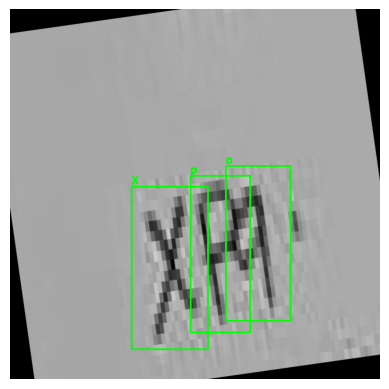

In [322]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt


transformed_image, transformed_bboxes, transformed_labels, err = augment_image(data_bbx[1]["image"], data_bbx[1]["bboxs"])
class_labels = [classes_map[bbox["char"]] for bbox in data_bbx[1]["bboxs"]]
# Visualize (convert YOLO back to pixel coordinates for drawing)
h, w, _ = transformed_image.shape
for bbox, label in zip(transformed_bboxes, class_labels):
    x_c, y_c, bw, bh = bbox
    x_min = int((x_c - bw / 2) * w)
    y_min = int((y_c - bh / 2) * h)
    x_max = int((x_c + bw / 2) * w)
    y_max = int((y_c + bh / 2) * h)
    cv2.rectangle(transformed_image, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
    cv2.putText(transformed_image, classes[label], (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [323]:
run_data_augmentaiton(data_bbx, AUG_DATA_PATH, 5)

0 :  Augmenting 158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c
5 :  Augmenting 158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.b6c74acaac0ff1919103b0cae8194309
10 :  Augmenting 20230314_201442-3-_jpg.rf.5d18a3a3dbce20aace2d8dd6541f5401
15 :  Augmenting 20230314_201442-4-_jpg.rf.2bc9c1f860cf8b97e86fd5307cad9455
15 :  Augmenting 20230314_201612-2-_jpg.rf.7df74050e9557ed418fe44cd37c23704
15 :  Augmenting 20230314_201612-3-_jpg.rf.1c82d2962fbaebd21f295b9c4f5b9830
15 :  Augmenting 20230314_201612-3-_jpg.rf.42d52c3b46136823e249d70ca53bee4b
15 :  Augmenting 20230513_000658-3-_jpg.rf.ae8bdd66111fe69496b371987d42a3b3
15 :  Augmenting 20230513_000658-4-_jpg.rf.e57ba7ec7c30b66ffad6f2631be1f48f
15 :  Augmenting 20230513_000658-5-_jpg.rf.cb728671188bcc6e439ee0270fc3f133
15 :  Augmenting 20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54
15 :  Augmenting 20230513_000658-6-_jpg.rf.32871c9db4d646697afd1390c0c62260
15 :  Augmenting 274610921

In [324]:
CUSTOM_IMAGES_PATH = os.path.join(DATA_ROOT, "Handwriting dataset_lanre/images/*.jpg")
CUSTOM_LABELS_PATH = os.path.join(DATA_ROOT, "Handwriting dataset_lanre/labels/*.txt")
ROOT_CUSTOM_PATH = os.path.join(DATA_ROOT, "custom_dataset")
custom_images_list = glob.glob(CUSTOM_IMAGES_PATH)

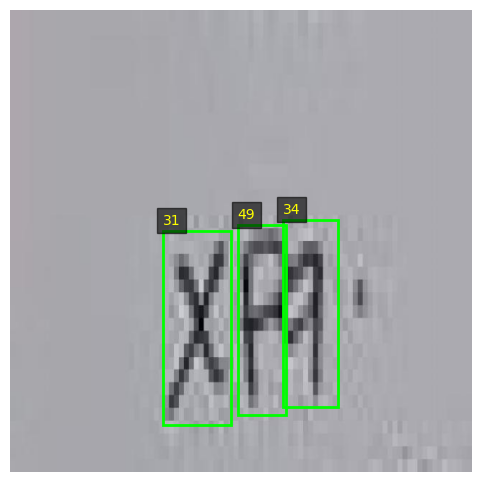

In [325]:
draw_yolo_labels_on_image(image_list[0], label_path=label_list[0], show=True)

In [296]:
for i in custom_images_list:
  new_img = preprocess_image(i, (640, 640))
  os.makedirs(os.path.join(DATA_ROOT, "Handwriting dataset_lanre/preprocessed_images"), exist_ok=True)
  new_img.save(os.path.join(DATA_ROOT, "Handwriting dataset_lanre/preprocessed_images", os.path.basename(i)))
  print(os.path.basename(i))

IMG_1410 1.jpg
IMG_1411 1.jpg
IMG_1412 5.jpg
IMG_1410 9.jpg
IMG_1411 2.jpg
IMG_1412 3.jpg
IMG_1410 5.jpg


KeyboardInterrupt: 

# Task
Train a YOLO model on a dataset to detect letters in images.

## Install necessary libraries

### Subtask:
Install the required libraries for YOLO training, such as `ultralytics`.


In [297]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.2 MB/s eta 0:00:00


## Prepare data for yolo

Ensure  dataset is in the correct YOLO format, with images and corresponding text files containing bounding box annotations and class labels. Based on the previous steps, it seems like the data is already in this format, but we should confirm.


## Configure yolo model


configureits parameters for training, including specifying the number of classes, input image size, and training hyperparameters.


In [340]:
from ultralytics import YOLO
import yaml

# Load a pre-trained YOLO model
model = YOLO()

# Define data dictionary
data = {
    'train': os.path.join(DATA_ROOT, 'Doctors prescriptions handwriting.v1i.yolov8 2', 'train'),
    'val': os.path.join(DATA_ROOT, 'Doctors prescriptions handwriting.v1i.yolov8 2', 'valid'),
    'nc': len(classes),
    'names': classes
}

# Define the path to save the YAML file
yaml_path = os.path.join(DATA_ROOT, 'dataset.yaml')

# Save the data dictionary to a YAML file
with open(yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"Dataset configuration saved to {yaml_path}")

Dataset configuration saved to /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml


## Train the yolo model

### Subtask:
Train the YOLO model on your prepared dataset using the configured parameters.


**Reasoning**:
Train the YOLO model using the specified parameters: 25 epochs, image size 640, patience 5, and batch size 16.



In [336]:
!rm -rf /content/runs

In [341]:
# Use the path to the YAML file for training
results = model.train(data=yaml_path, epochs=25, imgsz=640, patience=5, batch=16, project=DATA_ROOT, name="training")  # custom directory


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overl

In [342]:
def run_sample_test(checkpoint_path, img_paths=None):
  # Choose a sample image to test
  if img_paths == None:
    sample_image_path = image_list[0] # Using the first image from the list as an example
    sample_image_path2 = image_list[10] # Using the first image from the list as an example
  else:
    sample_image_path = img_paths[0]
    sample_image_path2 = img_paths[1] # Using the first image from the list as an example

  # Perform inference
  results = model(sample_image_path)
  results2 = model(sample_image_path2)

  # Visualize the results
  results[0].show()
  results2[0].show()



image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 x, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 i, 1 o, 1 t, 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


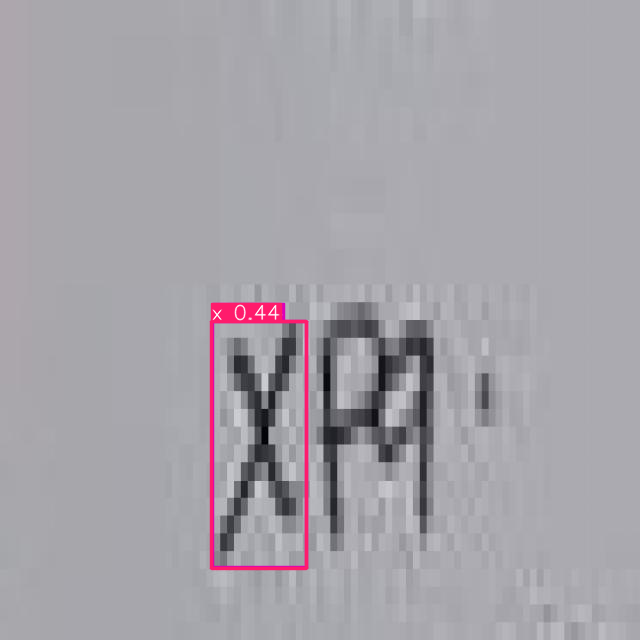

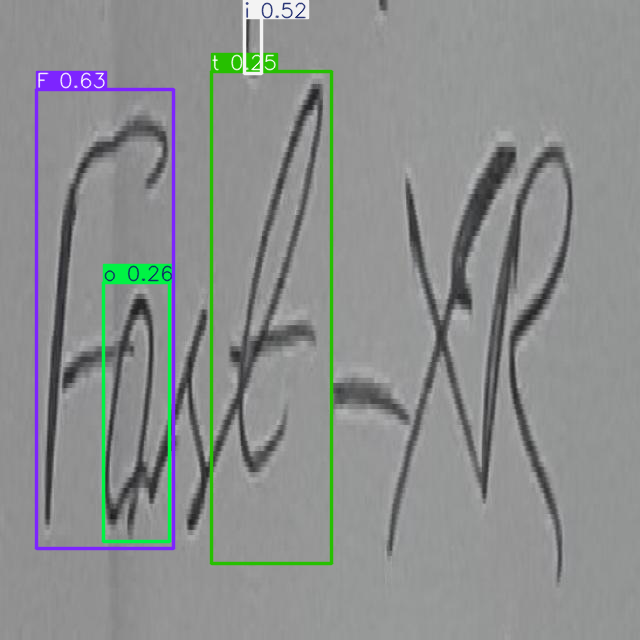

In [343]:
chk_pth = os.path.join(DATA_ROOT,'training12/weights/best.pt')
run_sample_test(chk_pth)

### Run training for different epochs up by 20

In [344]:
last_checkpoint = os.path.join(DATA_ROOT,'training12/weights/best.pt')
model = YOLO(last_checkpoint)
results = model.train(data=yaml_path, epochs=40, imgsz=640, patience=5, batch=16, project=DATA_ROOT, name="training")  # custom directory

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/training12/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fa


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 a, 1 p, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 1 X, 1 t, 1 u, 1 x, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


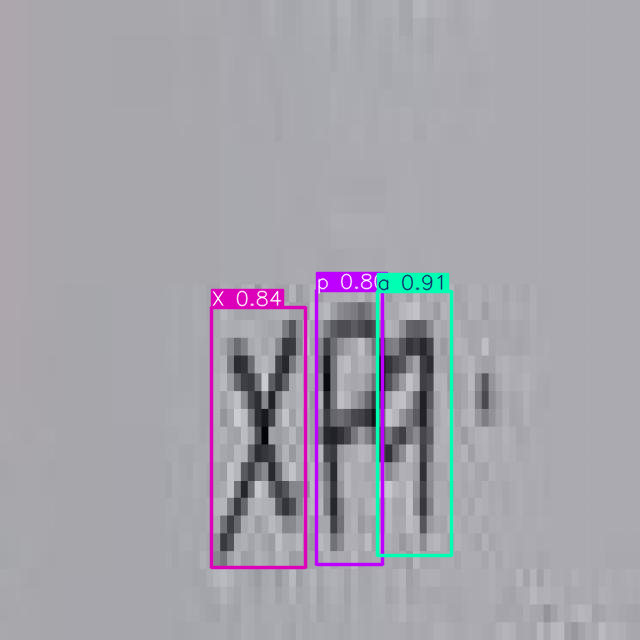

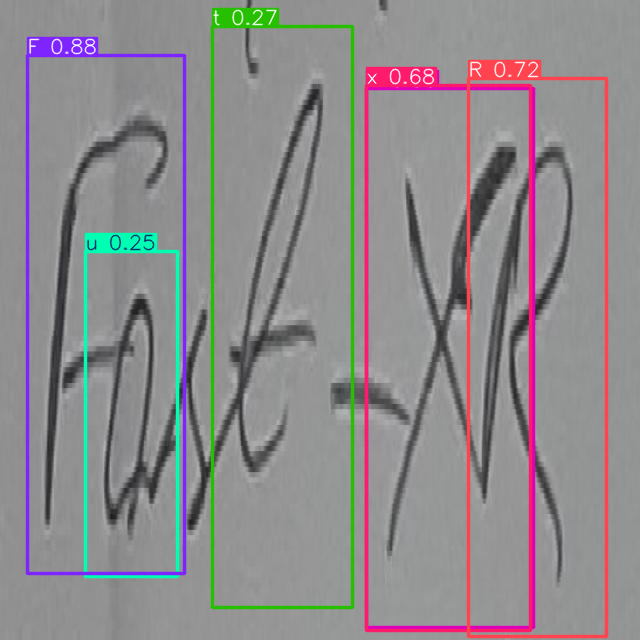

In [345]:
chk_pth = os.path.join(DATA_ROOT,'training13/weights/best.pt')
run_sample_test(chk_pth)

In [348]:
last_checkpoint = os.path.join(DATA_ROOT,'training/weights/best.pt')
model = YOLO(last_checkpoint)
results = model.train(data=yaml_path, epochs=20, imgsz=640, patience=5, batch=16, project=DATA_ROOT, name="training")  # custom directory

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/training/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 a, 1 p, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 1 X, 1 a, 1 t, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


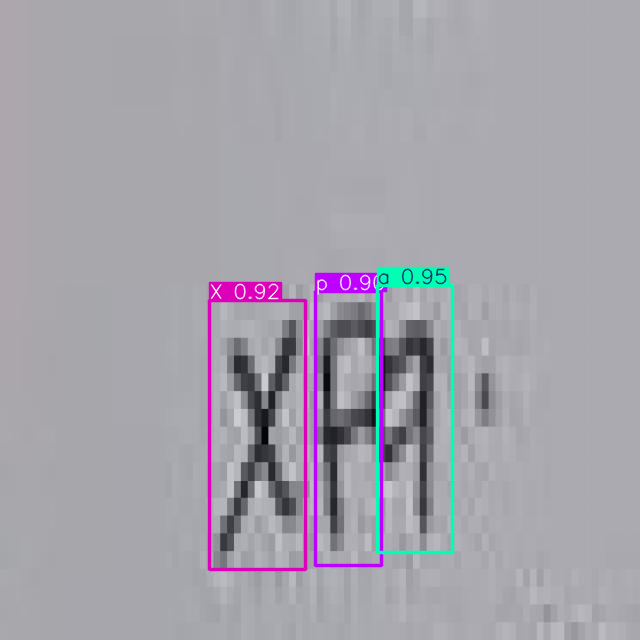

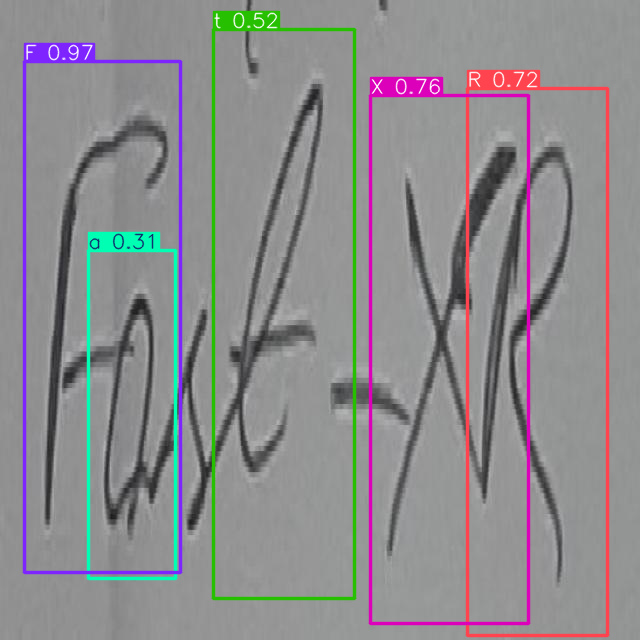

In [349]:
chk_pth = os.path.join(DATA_ROOT,'training2/weights/best.pt')
run_sample_test(chk_pth)

#### giving it more patience to see if it actually remains still after 51 epochs (might be different since batch size also changed)

In [350]:
last_checkpoint = os.path.join(DATA_ROOT,'training2/weights/best.pt')
model = YOLO(last_checkpoint)
results = model.train(data=yaml_path, epochs=20, imgsz=640, patience=10, batch=16, project=DATA_ROOT, name="training")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/training2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fal


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 a, 1 p, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 1 X, 1 a, 1 t, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


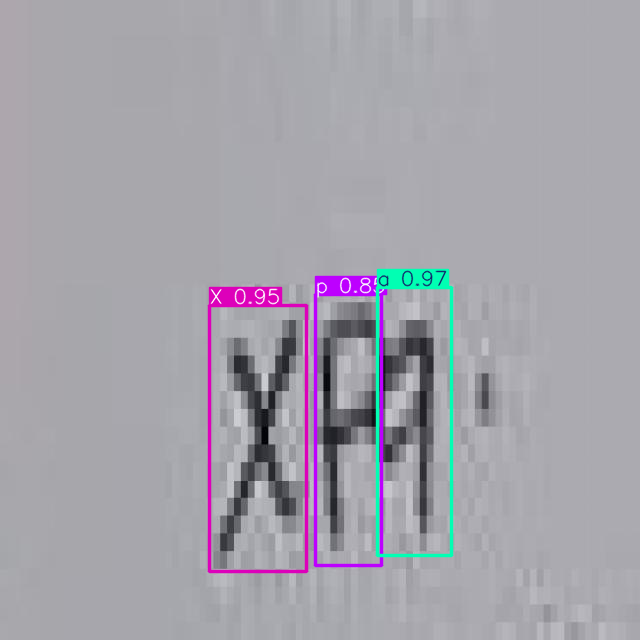

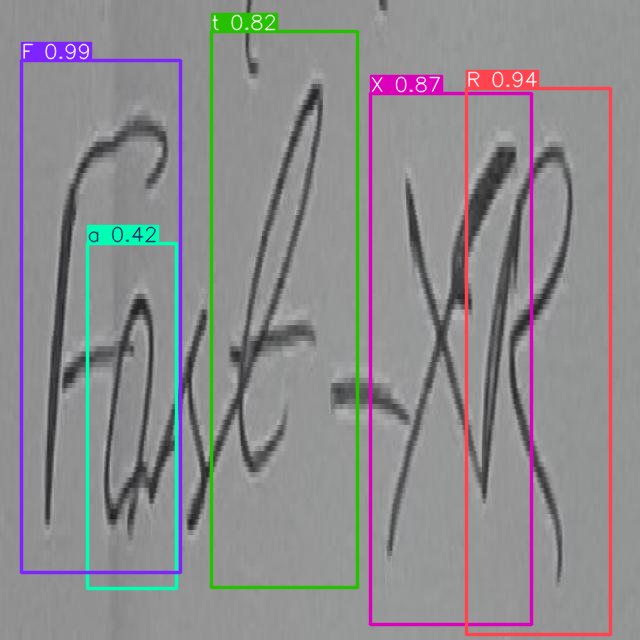

In [351]:
chk_pth = os.path.join(DATA_ROOT,'training3/weights/best.pt')
run_sample_test(chk_pth)

#### This approach seems to be working better im going to continue the training using the checkpoint from the last run.

In [352]:
last_checkpoint = os.path.join(DATA_ROOT,'training3/weights/best.pt')
model = YOLO(last_checkpoint)
results = model.train(data=yaml_path, epochs=20, imgsz=640, patience=10, batch=16, project=DATA_ROOT, name="training")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/training3/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fal


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 a, 1 p, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 1 X, 1 a, 1 s, 1 t, 9.4ms
Speed: 1.4ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


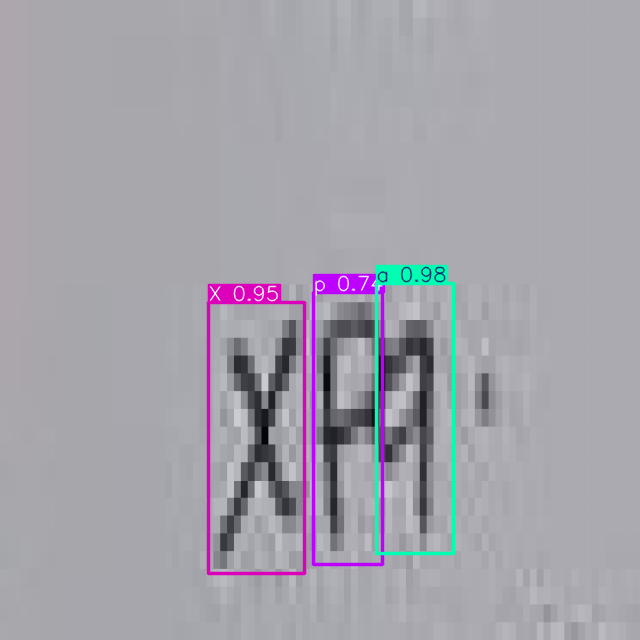

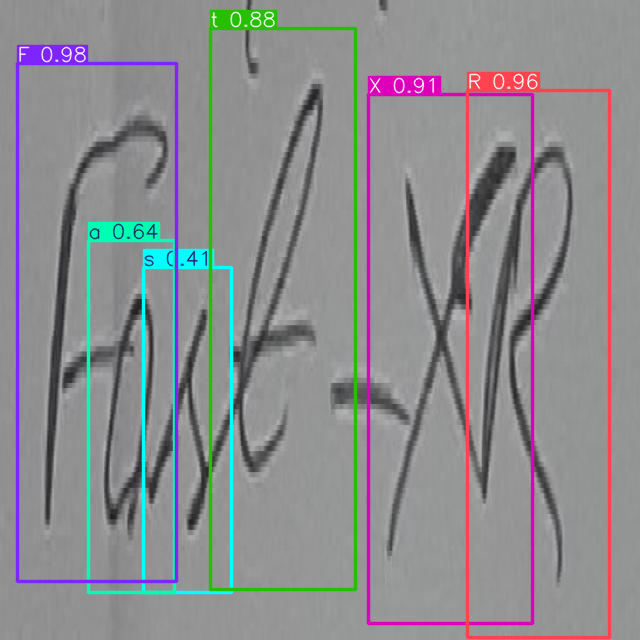

In [353]:
chk_pth = os.path.join(DATA_ROOT,'training4/weights/best.pt')
run_sample_test(chk_pth)

#### Model has improved significantly but loss still reducing (Continuing the training with last checkpoint)

In [355]:
last_checkpoint = os.path.join(DATA_ROOT,'training4/weights/best.pt')
model = YOLO(last_checkpoint)
results = model.train(data=yaml_path, epochs=20, imgsz=640, patience=10, batch=16, project=DATA_ROOT, name="training")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/training4/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fal


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 a, 1 p, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 1 X, 1 a, 1 s, 1 t, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


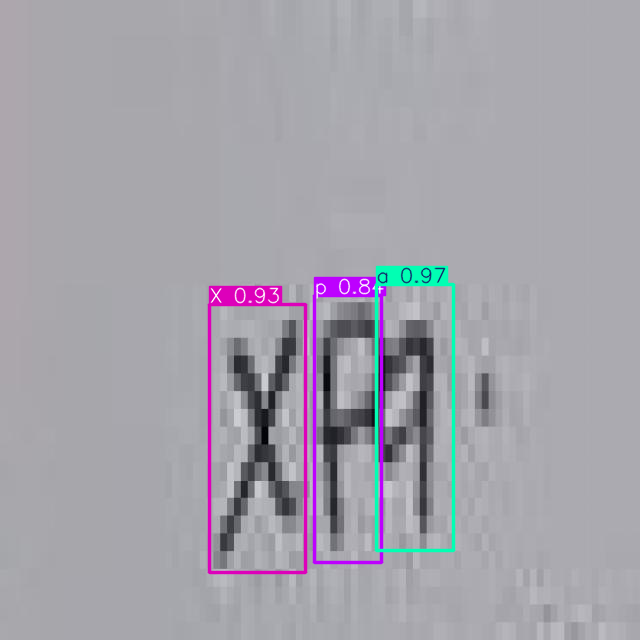

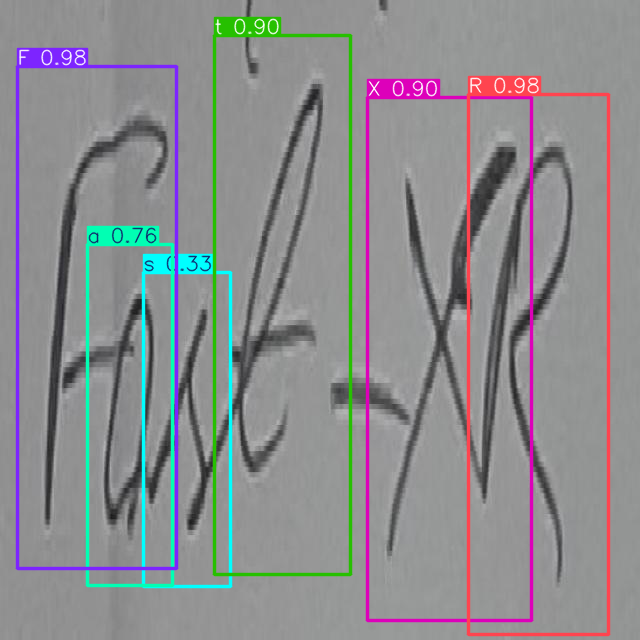

In [356]:
chk_pth = os.path.join(DATA_ROOT,'training5/weights/last.pt')
run_sample_test(chk_pth)

In [358]:
# Load the best trained model
last_checkpoint = os.path.join(DATA_ROOT,'training5/weights/best.pt')
model = YOLO(last_checkpoint)

# Validate the model and generate performance metrics and plots
results = model.val(plots=True)

# The results object contains the performance metrics
print("Performance Metrics:")
print(results.results_dict)

# The confusion matrix and other plots are saved in the 'runs' directory
print(f"\nConfusion matrix and other plots saved in: {results.save_dir}")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,593,852 parameters, 0 gradients, 6.4 GFLOPs
val: Fast image access ✅ (ping: 1.2±1.6 ms, read: 7.1±5.0 MB/s, size: 22.6 KB)
val: Scanning /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/valid/labels.cache... 100 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 58.4Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 817, len(boxes) = 950. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.2it/s 3.1s
                   all        100        950      0.545      0.463      0.461      0.289
                     0         42

Confusion Matrix:


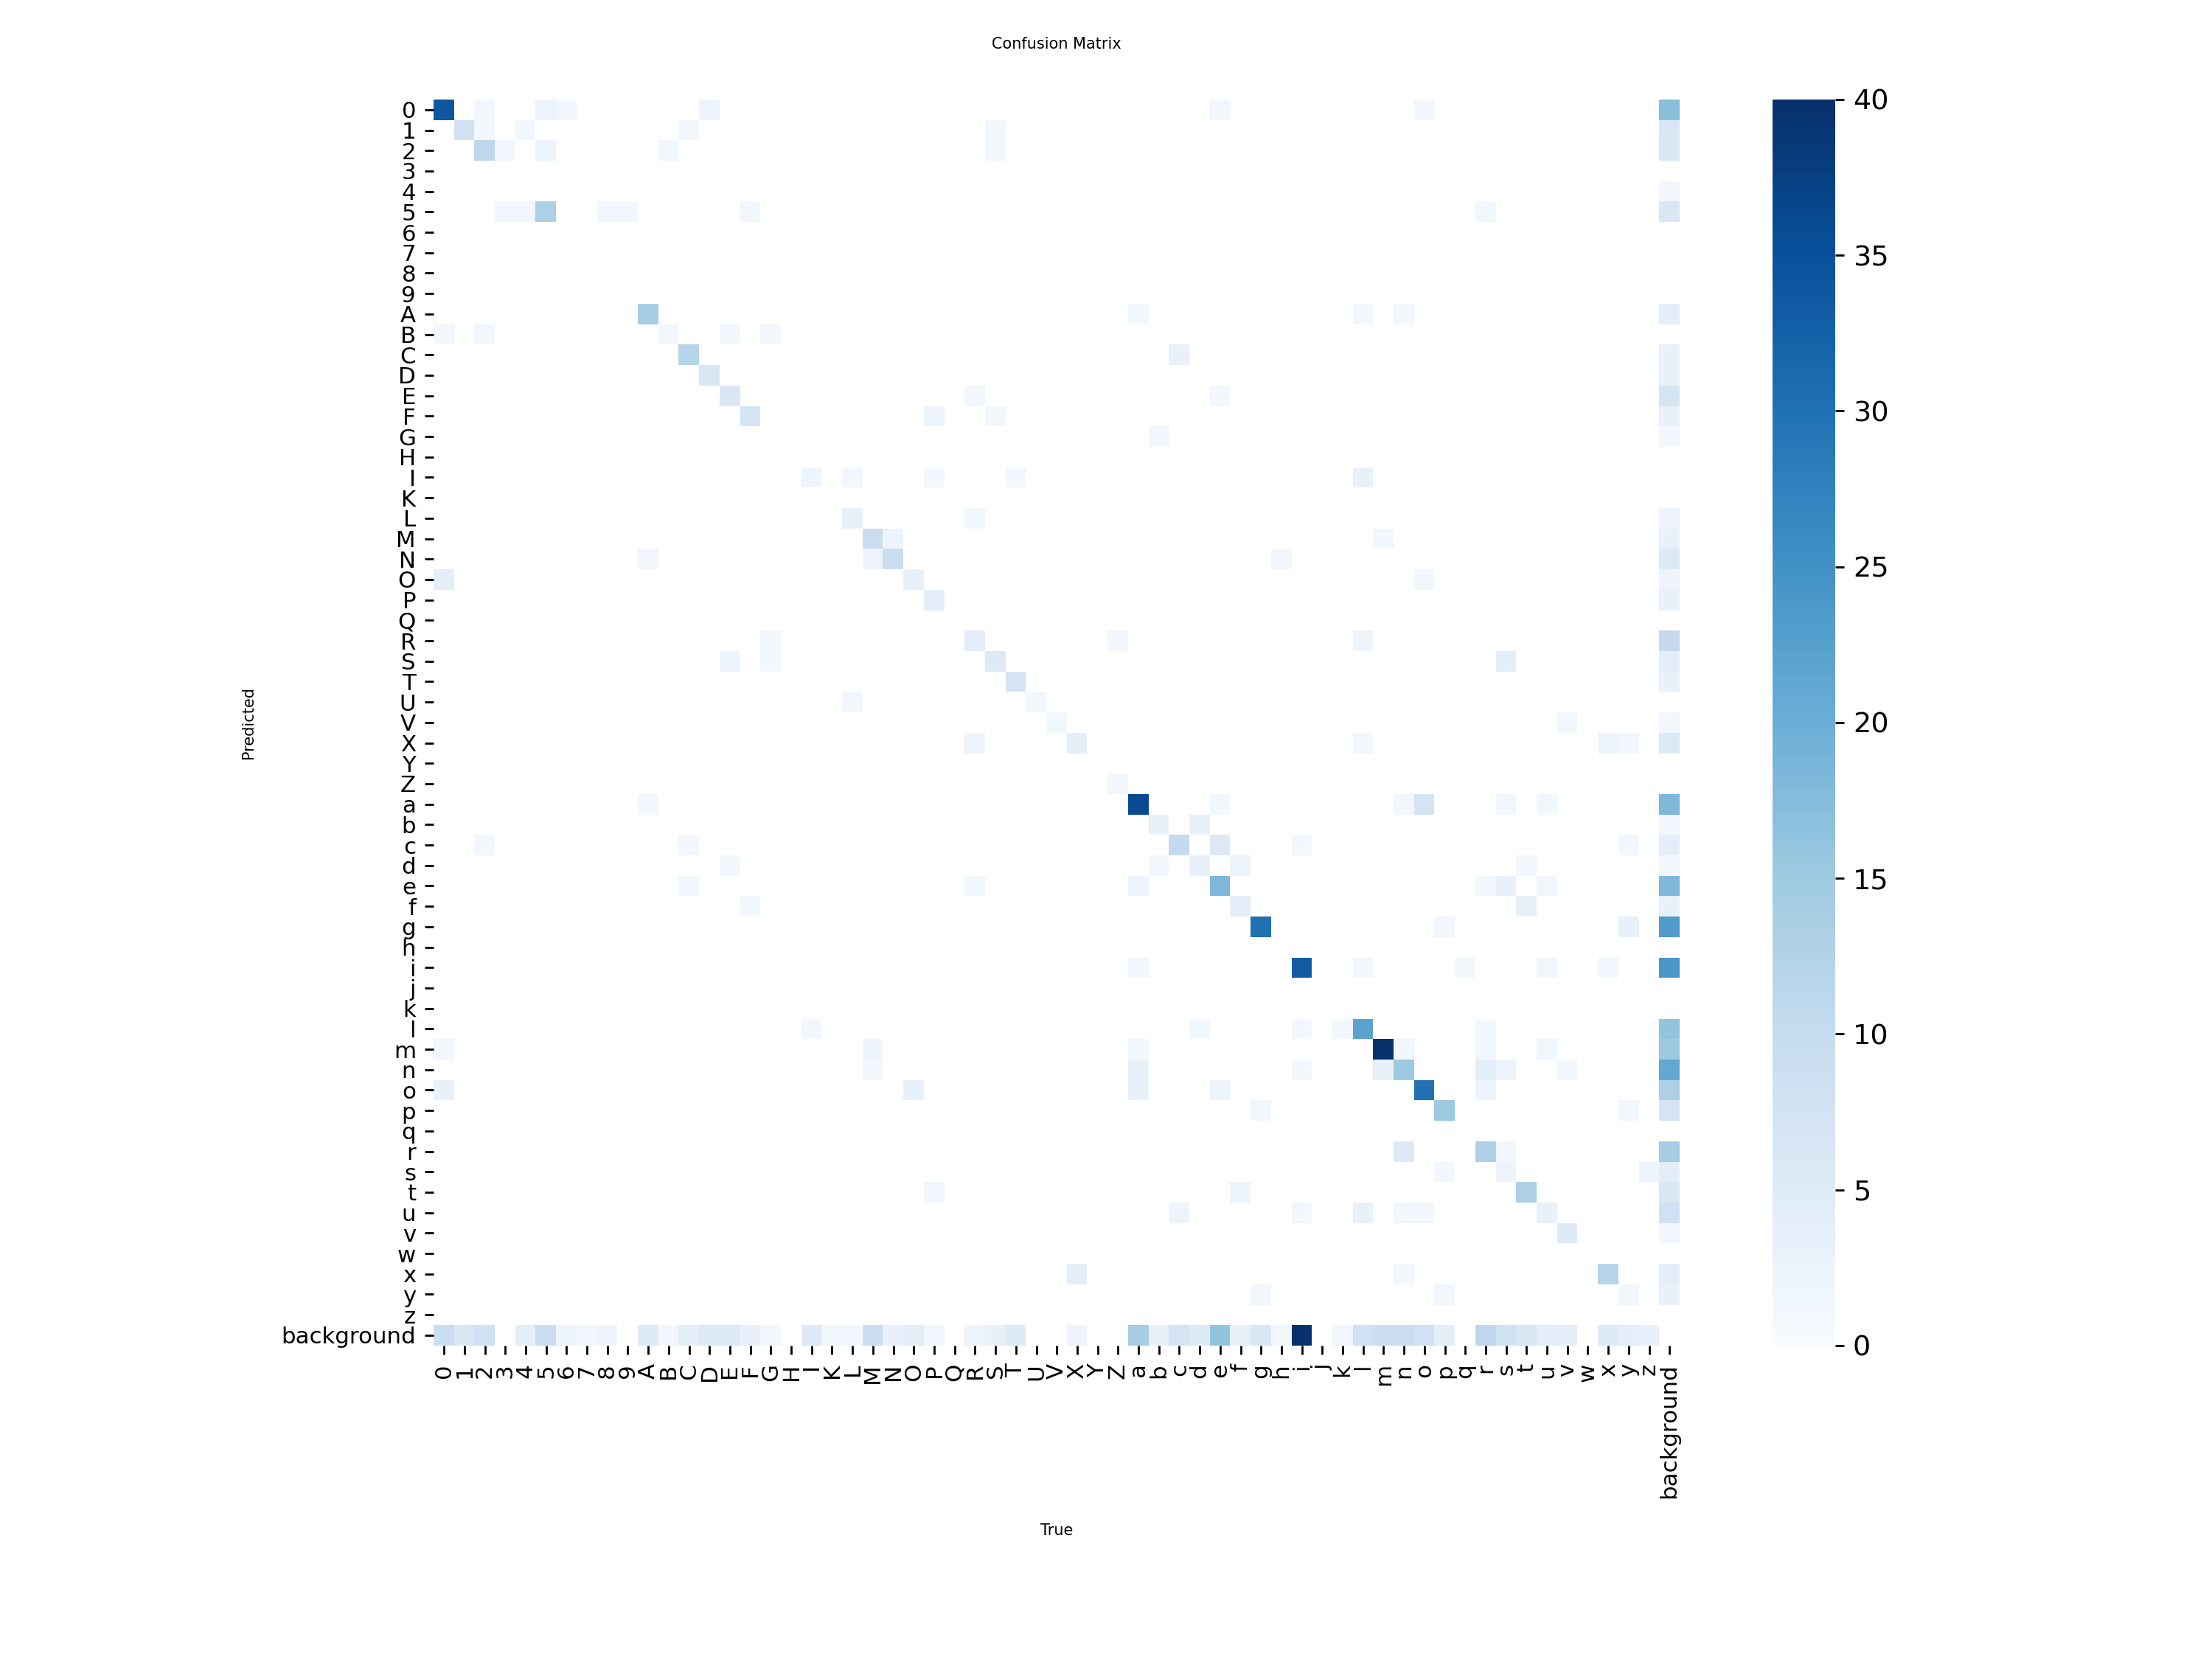

In [359]:
from IPython.display import Image, display
import os

# Assuming the plots are saved in the last validation run directory
# You can find the exact path from the output of the previous cell (results.save_dir)
runs_dir = results.save_dir

# Path to the saved plots
confusion_matrix_path = os.path.join(runs_dir, 'confusion_matrix.png')

# Display the plots
print("Confusion Matrix:")
display(Image(filename=confusion_matrix_path, width=800)) # Adjust width as needed

### Testing on custom dataset created by us

In [378]:
# deleting images without labels

In [380]:
import os
import glob

# Define the path to the custom dataset images and labels
CUSTOM_IMAGES_PATH_DIR = os.path.join(DATA_ROOT, "custom_dataset/images")
CUSTOM_LABELS_PATH_DIR = os.path.join(DATA_ROOT, "custom_dataset/labels")

# Get a list of all image files
custom_image_files = glob.glob(os.path.join(CUSTOM_IMAGES_PATH_DIR, "*.jpg"))

deleted_count = 0
# Iterate through the image files
for image_file in custom_image_files:
    # Get the base name of the image file (without extension)
    image_basename = os.path.splitext(os.path.basename(image_file))[0]

    # Construct the path to the corresponding label file
    label_file = os.path.join(CUSTOM_LABELS_PATH_DIR, f"{image_basename}.txt")

    # Check if the label file exists
    if not os.path.exists(label_file):
        # If the label file does not exist, delete the image file
        try:
            os.remove(image_file)
            print(f"Deleted image with no label: {image_file}")
            deleted_count += 1
        except OSError as e:
            print(f"Error deleting file {image_file}: {e}")

print(f"\nFinished checking images. Deleted {deleted_count} images without corresponding label files.")


Finished checking images. Deleted 0 images without corresponding label files.


In [381]:
import os
import glob
import cv2
import albumentations as A
import numpy as np
from tqdm import tqdm # Import tqdm for progress bar

def preprocess_and_resize(image_path, label_path, size=(640, 640)):
    """
    Resizes an image and its YOLO labels to the specified size using Albumentations
    and saves them back to the original paths.

    Args:
        image_path: Path to the image file.
        label_path: Path to the YOLO label file.
        size: A tuple representing the target size (width, height).
    """
    # Define the resize transform
    transform = A.Compose([
        A.Resize(height=size[1], width=size[0], p=1),
    ],
    bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['labels'],
        min_visibility=0.0, # Keep all bounding boxes during resize
    ))

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}. Skipping.")
        return

    # Read the YOLO labels
    bboxes = []
    class_labels = []
    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    try:
                        # Attempt to convert class_id to float first, then int
                        class_id = int(float(parts[0]))
                        # Check for invalid class IDs like -1
                        if class_id < 0:
                            print(f"Warning: Skipping invalid negative class ID in {label_path}: {line.strip()}")
                            continue
                        # YOLO format: class_id x_center y_center width height
                        bbox = [float(p) for p in parts[1:]] # Extract only the 4 coordinates
                        bboxes.append(bbox)
                        class_labels.append(class_id)
                    except ValueError:
                        print(f"Warning: Skipping malformed class ID in {label_path}: {line.strip()}")
                        continue
                else:
                    print(f"Warning: Skipping malformed line in label file {label_path}: {line.strip()} (Expected 5 values, found {len(parts)})")
    except FileNotFoundError:
        print(f"Warning: Label file not found for {image_path}. Skipping.")
        return
    except Exception as e:
        print(f"Error reading label file {label_path}: {e}. Skipping.")
        return


    if not bboxes:
        print(f"Warning: No valid bounding boxes found in {label_path}. Skipping image.")
        return

    try:
        # Apply the transform
        transformed = transform(image=image, bboxes=bboxes, labels=class_labels)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_labels = transformed['labels']
    except Exception as e:
        print(f"Error applying Albumentations transform to {image_path}: {e}. Skipping.")
        return


    # Save the transformed image and labels back to original paths
    cv2.imwrite(image_path, transformed_image)

    with open(label_path, 'w') as f:
        for bbox, label in zip(transformed_bboxes, transformed_labels):
            # Save in YOLO format: class_id x_center y_center width height
            f.write(f"{int(label)} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")


# Process all images and labels
for image_file in tqdm(custom_image_files, desc="Processing Custom Dataset"):
    label_file = os.path.join(CUSTOM_LABELS_PATH_DIR, os.path.splitext(os.path.basename(image_file))[0] + '.txt')
    if os.path.exists(label_file): # Only process if label file exists
        preprocess_and_resize(image_file, label_file)
    else:
        print(f"Skipping {image_file} as no corresponding label file was found.")

print("\nFinished processing custom dataset.")

Processing Custom Dataset:  73%|███████▎  | 47/64 [01:24<00:26,  1.57s/it]

Processing Custom Dataset: 100%|██████████| 64/64 [01:56<00:00,  1.82s/it]


Finished processing custom dataset.


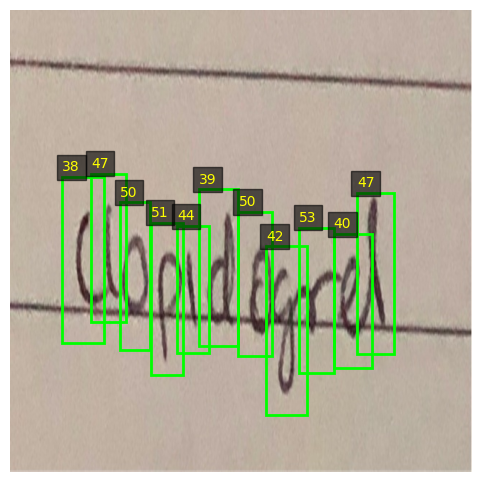

In [382]:
# Select a sample custom image and label file
sample_image_path = os.path.join(CUSTOM_IMAGES_PATH_DIR, os.listdir(CUSTOM_IMAGES_PATH_DIR)[0])
sample_label_path = os.path.join(CUSTOM_LABELS_PATH_DIR, os.path.splitext(os.path.basename(sample_image_path))[0] + '.txt')

# Visualize the image with bounding boxes
if os.path.exists(sample_label_path):
    draw_yolo_labels_on_image(sample_image_path, label_path=sample_label_path, show=True)
else:
    print(f"Label file not found for {sample_image_path}")

In [383]:
sample_image = custom_images_list[0]
sample_image2 = custom_images_list[1]

In [384]:
import os
import yaml
from ultralytics import YOLO

# Define the path to the custom dataset images and labels
CUSTOM_DATASET_PATH = os.path.join(DATA_ROOT, 'Handwriting dataset_lanre') # Assuming the parent directory contains both images and labels folders

# Define the data dictionary for validation on the custom dataset
custom_data = {
    'train': os.path.join(DATA_ROOT, 'Doctors prescriptions handwriting.v1i.yolov8 2', 'train'), # Include train path as it's required in the yaml
    'val': CUSTOM_DATASET_PATH,
    'nc': len(classes),
    'names': classes
}

# Define the path to save the YAML file for the custom dataset
custom_yaml_path = os.path.join(DATA_ROOT, 'custom_dataset.yaml')

# Save the data dictionary to a YAML file
with open(custom_yaml_path, 'w') as f:
    yaml.dump(custom_data, f)

print(f"Custom dataset configuration saved to {custom_yaml_path}")

# Load the best trained model (assuming 'training5' is the last successful training run)
last_checkpoint = os.path.join(DATA_ROOT,'training5/weights/best.pt')
model = YOLO(last_checkpoint)

results = model.val(data=custom_yaml_path, plots=True)

print("\nPerformance Metrics on Custom Dataset:")
print(results.results_dict)

print(f"\nConfusion matrix and other plots saved in: {results.save_dir}")

Custom dataset configuration saved to /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/custom_dataset.yaml
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,593,852 parameters, 0 gradients, 6.4 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 35.2±19.0 MB/s, size: 81.2 KB)
val: Scanning /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Handwriting dataset_lanre/labels... 32 images, 0 backgrounds, 10 corrupt: 100% ━━━━━━━━━━━━ 32/32 131.9it/s 0.2s
val: /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Handwriting dataset_lanre/images/IMG_1410 2.jpg: ignoring corrupt image/label: Label class 61 exceeds dataset class count 60. Possible class labels are 0-59
val: /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Handwriting dataset_lanre/images/IMG_1410 7.jpg: ignoring corrupt image/label: Label class 61 exceeds dat

### Performance is abysmal! on our custom dataset Training againg continuing form last checkpoint

In [ ]:
last_checkpoint = os.path.join(DATA_ROOT,'training5/weights/best.pt')
model = YOLO(last_checkpoint)
results = model.train(data=yaml_path, epochs=20, imgsz=640, patience=10, batch=16, project=DATA_ROOT, name="training")


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/custom_dataset/images/IMG_1410 4.jpg: 640x640 1 e, 2 ls, 1 n, 1 o, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/custom_dataset/images/20251019_024936988_iOS.jpg: 640x640 (no detections), 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


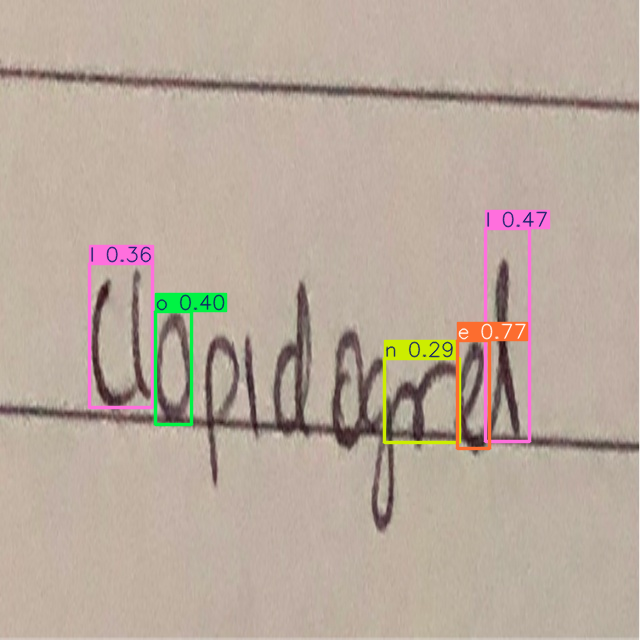

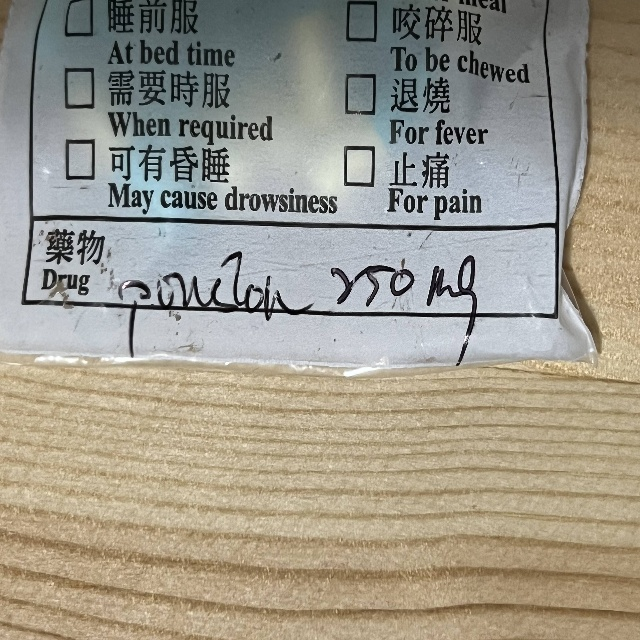

In [386]:
import glob
import os


sample_image = custom_image_files[0]
sample_image2 = custom_image_files[1]

# Load the best trained model
# You might want to adjust the path if you have a different training run you want to test
chk_pth = os.path.join(DATA_ROOT,'training6/weights/best.pt')
model = YOLO(chk_pth)

run_sample_test(chk_pth, [sample_image, sample_image2])

In [ ]:
# Define the path to the test data
TEST_PATH = os.path.join(DATA_ROOT, 'Doctors prescriptions handwriting.v1i.yolov8 2', 'test')

# Define the data dictionary for validation on the test set
test_data = {
    'train': os.path.join(DATA_ROOT, 'Doctors prescriptions handwriting.v1i.yolov8 2', 'train'), # Added train path
    'val': TEST_PATH,
    'nc': len(classes),
    'names': classes
}

# Define the path to save the YAML file
test_yaml_path = os.path.join(DATA_ROOT, 'test.yaml')

# Save the data dictionary to a YAML file
with open(test_yaml_path, 'w') as f:
    yaml.dump(test_data, f)

# Load the best trained model
last_checkpoint = os.path.join(DATA_ROOT,'training7/weights/best.pt')
model = YOLO(last_checkpoint)

# Validate the model on the test set and generate performance metrics and plots
results = model.val(data=test_yaml_path, plots=True)

# The results object contains the performance metrics
print("Performance Metrics on Test Set:")
print(results.results_dict)

# The confusion matrix and other plots are saved in the 'runs' directory
print(f"\nConfusion matrix and other plots saved in: {results.save_dir}")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,593,852 parameters, 0 gradients, 6.4 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.0±0.0 MB/s, size: 22.0 KB)
val: Scanning /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/test/labels... 50 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 1.1it/s 45.1s
val: /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/test/images/294102207_3303887066513383_6323161470553190259_n-2-_jpg.rf.b15fea714168d68122c15335bbcc14b4.jpg: 1 duplicate labels removed
val: New cache created: /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 302, len(boxes) = 399. To reso

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,593,852 parameters, 0 gradients, 6.4 GFLOPs
val: Fast image access ✅ (ping: 0.9±0.4 ms, read: 14.1±3.7 MB/s, size: 26.6 KB)
val: Scanning /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/valid/labels.cache... 100 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 127.8Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 817, len(boxes) = 950. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.0it/s 3.4s
                   all        100        950      0.545      0.463      0.461      0.289
                     0         

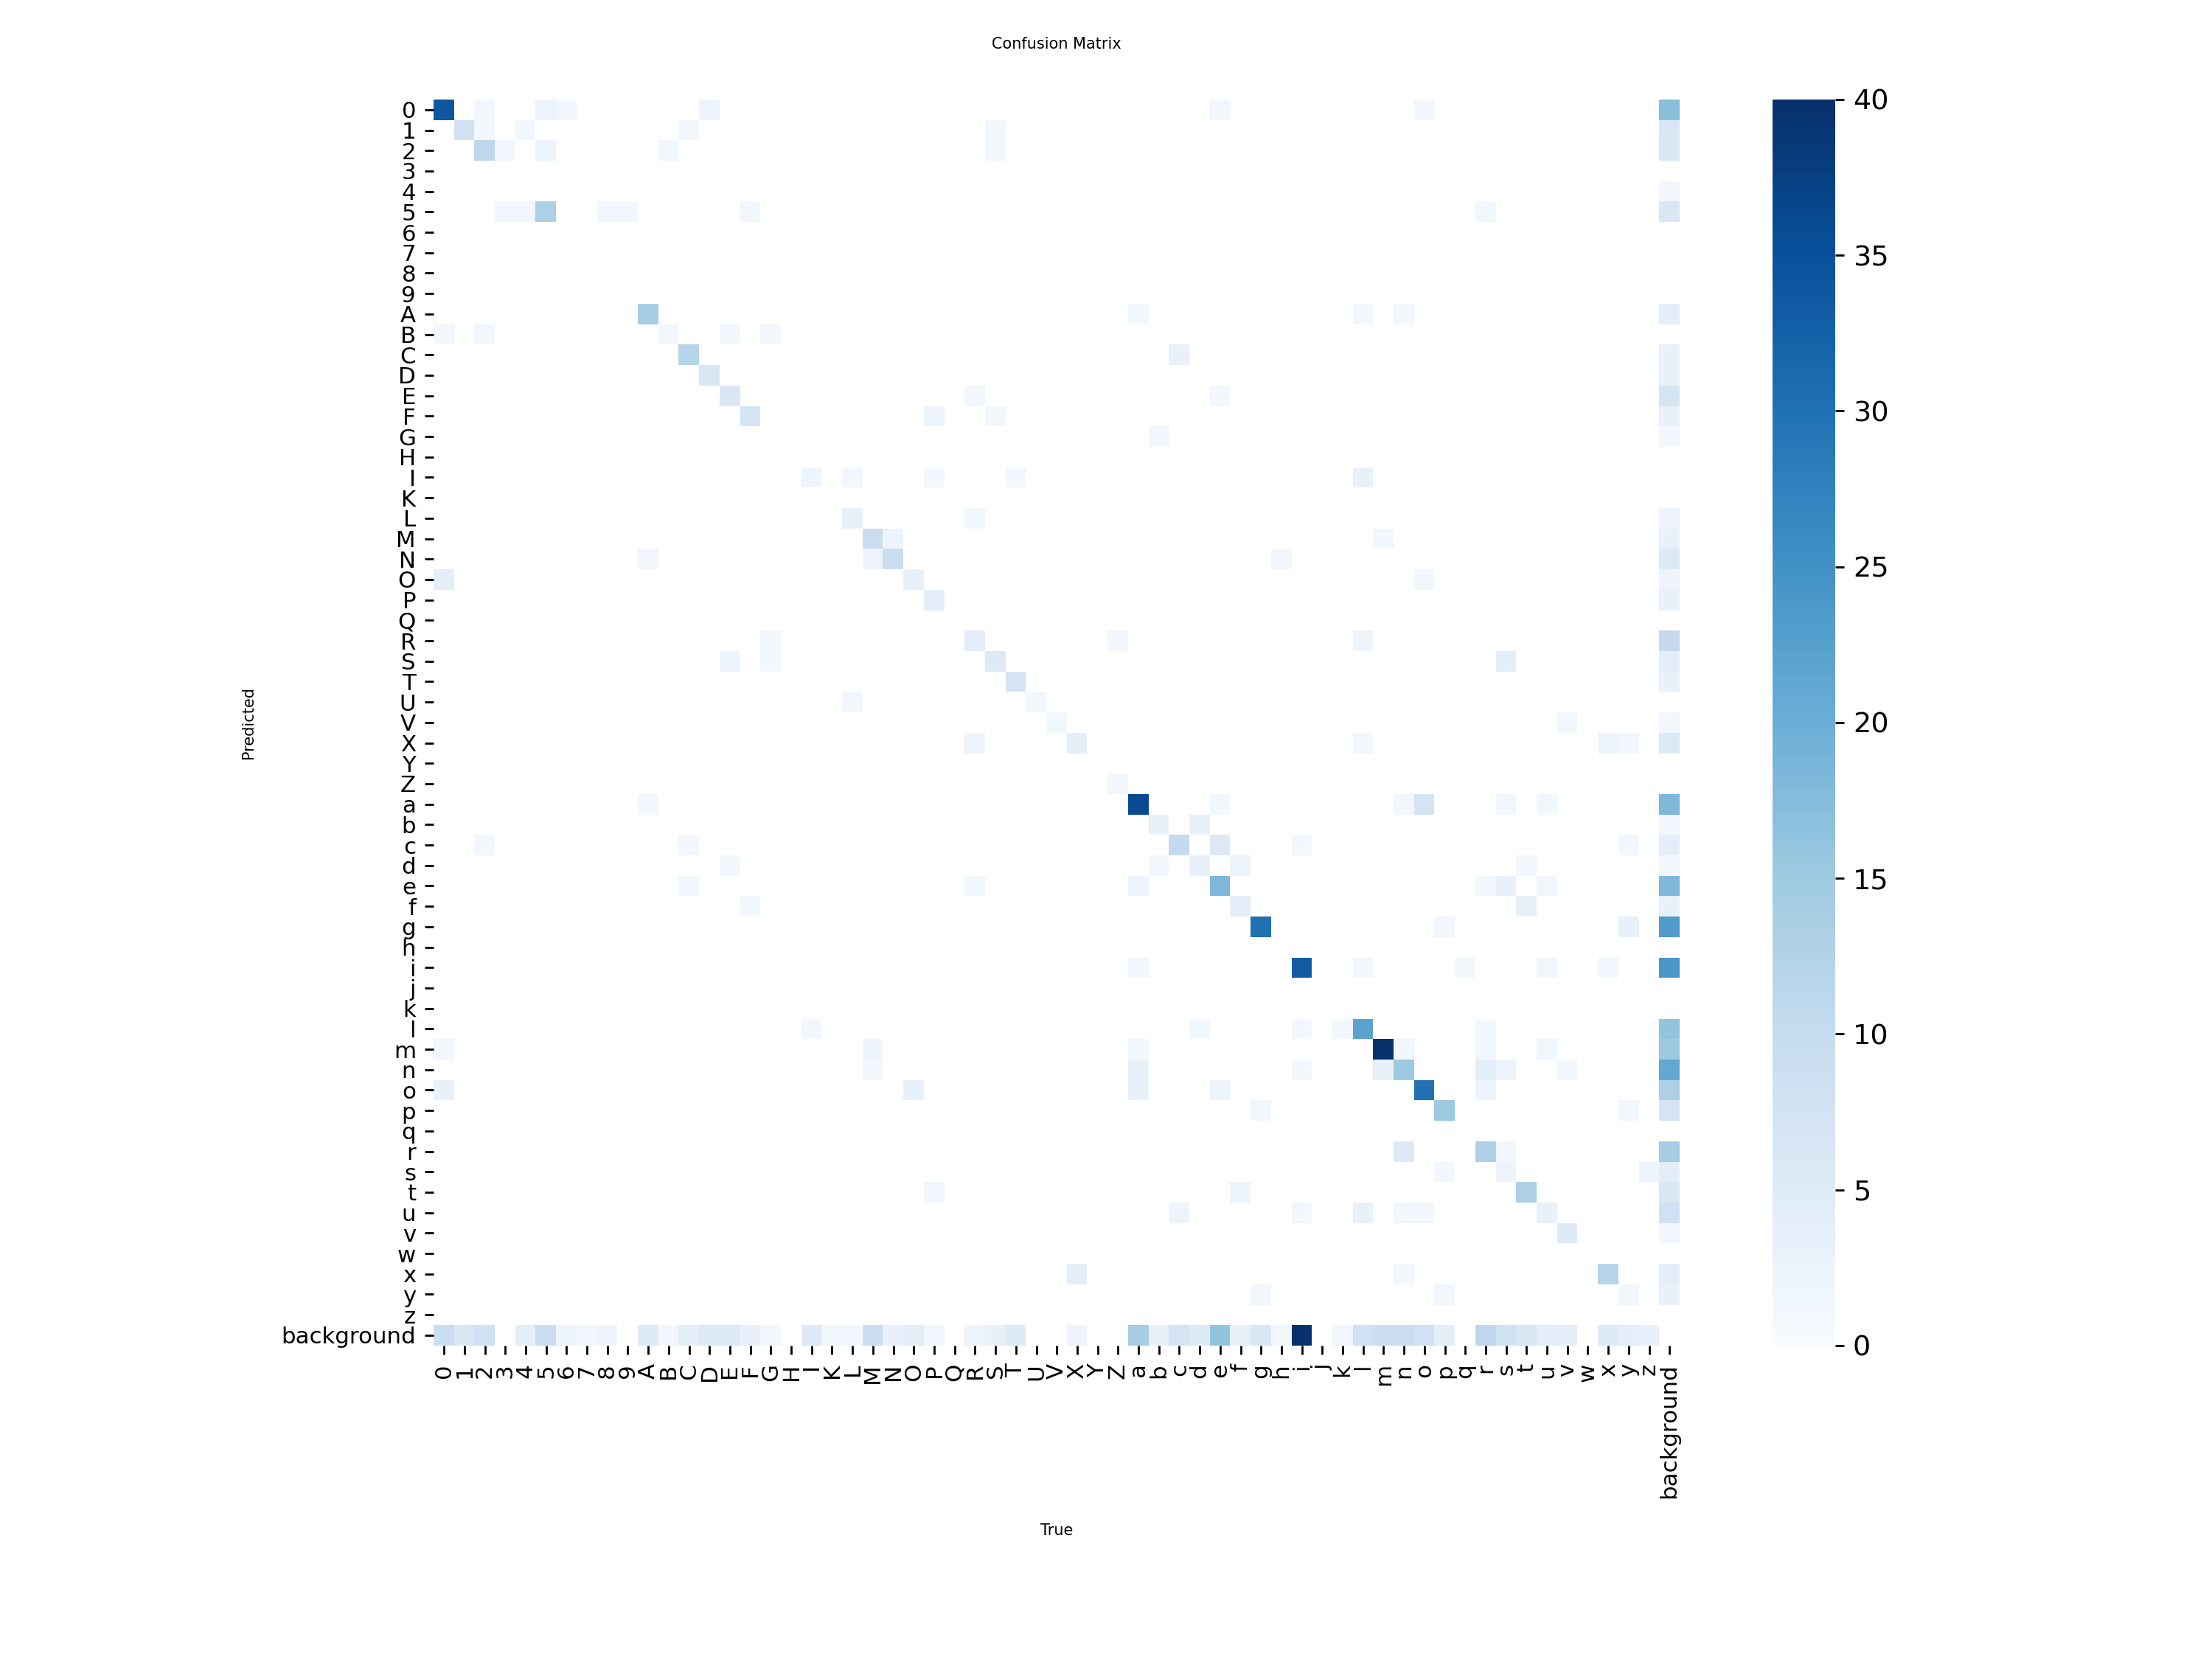


Results Plot:


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/val6/results.png'

In [388]:
# Load the best trained model
last_checkpoint = os.path.join(DATA_ROOT,'training5/weights/best.pt')
model = YOLO(last_checkpoint)

# Validate the model on the test set using the existing yaml file
results = model.val(data=yaml_path, plots=True)

# The results object contains the performance metrics
print("Performance Metrics on Test Set:")
print(results.results_dict)

# The confusion matrix and other plots are saved in the 'runs' directory
print(f"\nConfusion matrix and other plots saved in: {results.save_dir}")

from IPython.display import Image, display
import os

# Assuming the plots are saved in the last validation run directory
# You can find the exact path from the output of the previous cell (results.save_dir)
runs_dir = results.save_dir

# Path to the saved plots
confusion_matrix_path = os.path.join(runs_dir, 'confusion_matrix.png')
results_plot_path = os.path.join(runs_dir, 'results.png')
# Add paths for other plots you want to display, e.g., 'labels.jpg', 'val_batch0_pred.jpg'

# Display the plots
print("\nConfusion Matrix:")
display(Image(filename=confusion_matrix_path, width=800)) # Adjust width as needed

print("\nResults Plot:")
display(Image(filename=results_plot_path, width=800)) # Adjust width as needed


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 a, 1 p, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 1 X, 1 a, 1 s, 1 t, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


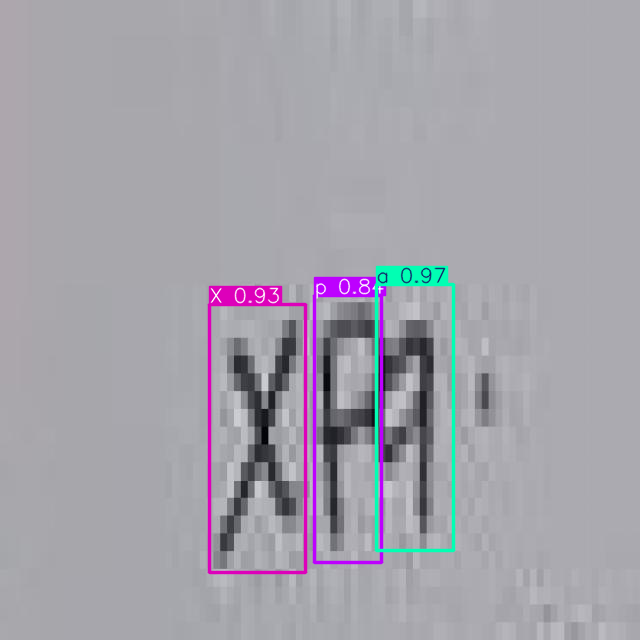

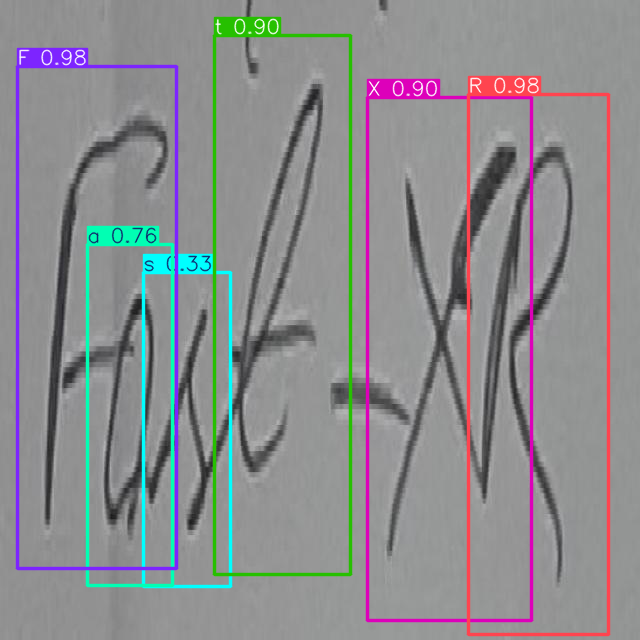

In [390]:
chk_pth = os.path.join(DATA_ROOT,'training5/weights/best.pt')
model = YOLO(chk_pth)
run_sample_test(chk_pth)


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/custom_dataset/images/20251019_024347078_iOS.jpg: 640x640 (no detections), 14.3ms
Speed: 4.2ms preprocess, 14.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/custom_dataset/images/20251019_084108000_iOS 1.jpg: 640x640 1 F, 3 as, 1 i, 2 ns, 15.4ms
Speed: 4.2ms preprocess, 15.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


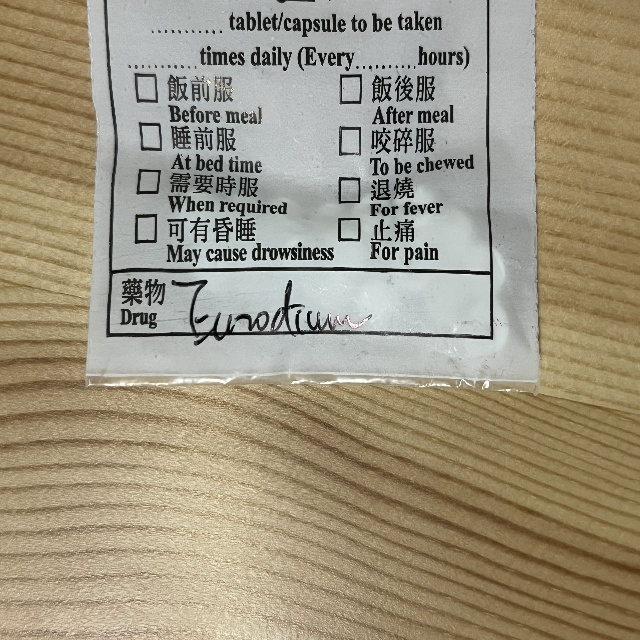

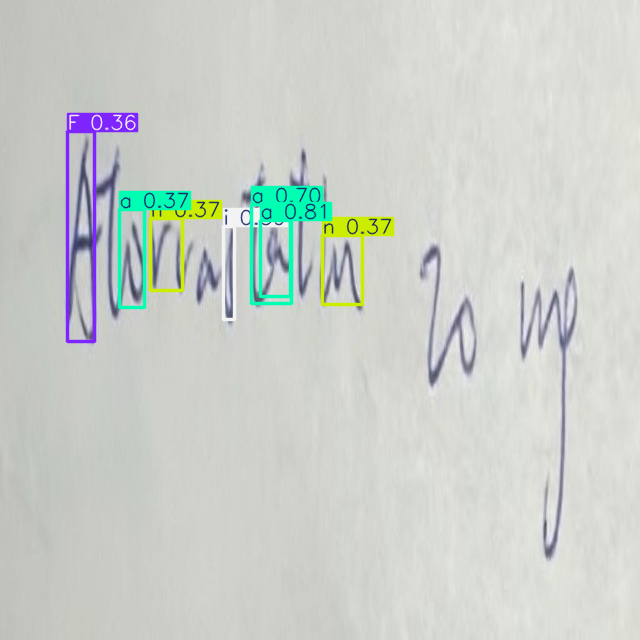

In [392]:
chk_pth = os.path.join(DATA_ROOT,'training5/weights/best.pt')
model = YOLO(chk_pth)
run_sample_test(chk_pth, [custom_image_files[5], custom_image_files[15]])

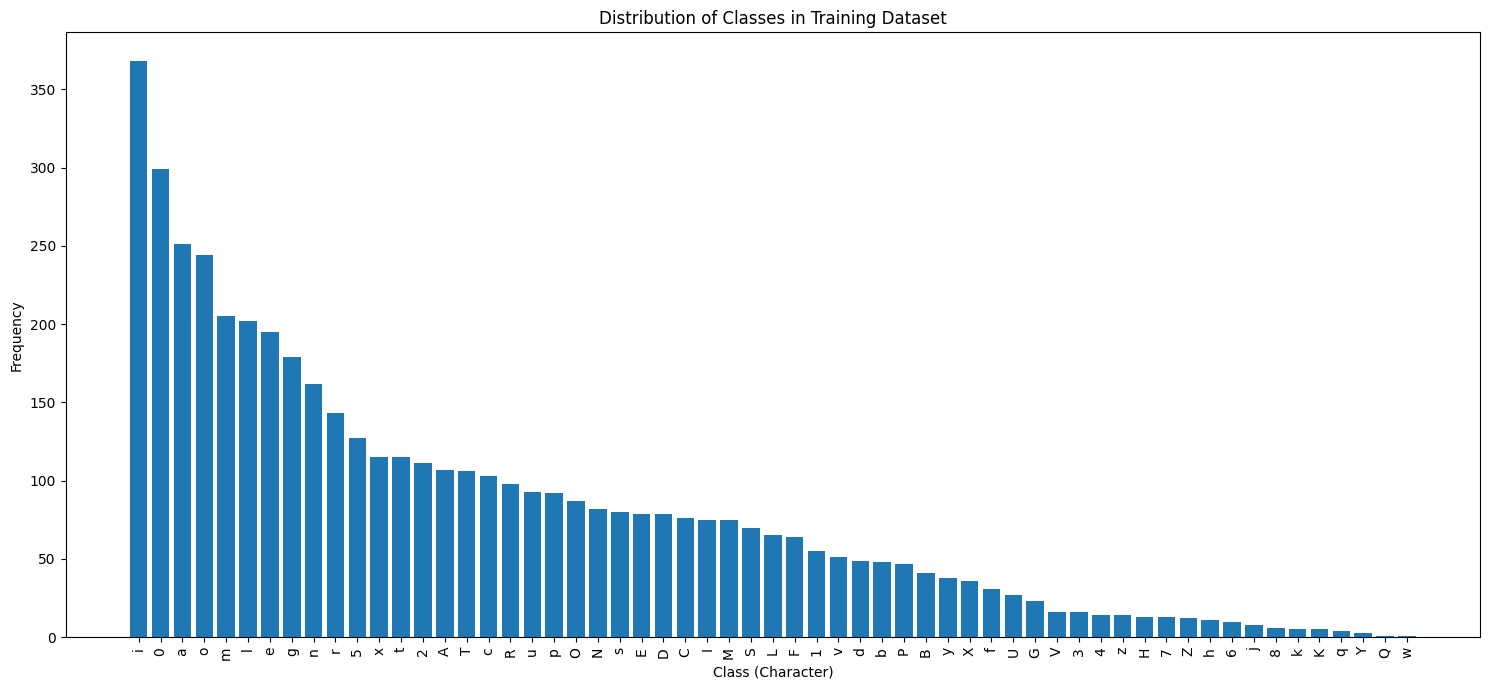

In [394]:
from collections import Counter
import matplotlib.pyplot as plt

# Extract all class labels from the data_bbx DataFrame
all_class_labels = [int(classes_map[bbox["char"]]) for entry in data_bbx for bbox in entry["bboxs"]]

# Count the occurrences of each class label
class_counts = Counter(all_class_labels)

# Get the class names based on the class IDs
class_names = [classes[class_id] for class_id in class_counts.keys()]
counts = list(class_counts.values())

# Sort the classes by count in descending order
sorted_indices = np.argsort(counts)[::-1]
sorted_class_names = [class_names[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]

# Create a bar chart
plt.figure(figsize=(15, 7))
plt.bar(sorted_class_names, sorted_counts)
plt.xlabel("Class (Character)")
plt.ylabel("Frequency")
plt.title("Distribution of Classes in Training Dataset")
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()